In [1]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import add_path
from toolkit.pipeline.data_io import SessionDirectory
from toolkit.allen_helpers.stimuli import *
from toolkit.pipeline.signal import *
import toolkit.analysis.spectrum as spec
from toolkit.plots import plots



pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

In [2]:
from toolkit.utils.module import reload_module

In [3]:
# SessionDirectory = reload_module('toolkit.pipeline.data_io', 'SessionDirectory')

## Get session and load data

In [4]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']

session_dir = SessionDirectory(session_id, ecephys_structure_acronym, cache_lfp=True)
session = session_dir.session

lfp_channels = session_dir.load_lfp_channels()
probe_info = session_dir.load_probe_info()

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [5]:
group_width = 0

lfp_groups, channel_groups = get_lfp_channel_groups(
    session_dir, probe_info['central_channels'], width=group_width
)

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
c:\Users\ziaochen\.conda\envs\neuro2\lib\site-pa

## Analyze data

In [6]:
stimulus_presentations = session.stimulus_presentations
session.stimulus_names

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings_contrast',
 'natural_movie_one_more_repeats',
 'natural_movie_one_shuffled',
 'drifting_gratings_75_repeats',
 'dot_motion']

In [7]:
session_type = session.session_type

if session_type == 'brain_observatory_1.1':
    stimulus_names = [
        'drifting_gratings',
        'natural_movie_one',
        'natural_movie_three',
        'static_gratings',
        'natural_scenes',
    ]
elif session_type == 'functional_connectivity':
    stimulus_names = [
        'drifting_gratings_75_repeats',
        'drifting_gratings_contrast',
        'natural_movie_one_more_repeats',
        'natural_movie_one_shuffled',
    ]

In [8]:
psd_tseg = 0.5  # segment duration in seconds
df = 1.0  # frequency resolution in Hz
psd_trials_das = {}
psd_avg_das = {}

plt_range = 100.
sxx_plt_range = [2.0, 80.0]

fit_freq_range = 200.
aperiodic_mode = 'knee'

In [9]:
stimulus_trials = {}

In [10]:
stim = stimulus_names[0]

In [11]:
stim_trials = get_stimulus_trials(stimulus_presentations, stimulus_name=stim)
stimulus_trials[stim] = stim_trials

aligned_lfp = align_trials(lfp_groups, stim_trials, window=(0., stim_trials.duration))

In [12]:
psd_trials = trial_psd(aligned_lfp, tseg=psd_tseg, df=df)
psd_avg = psd_trials.mean(dim='presentation_id', keep_attrs=True)

psd_trials_das[stim] = psd_trials
psd_avg_das[stim] = psd_avg

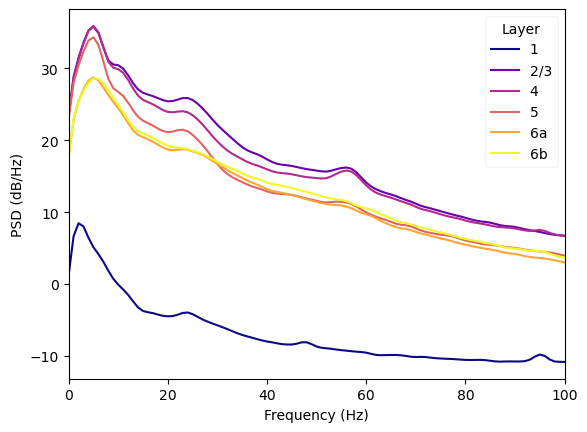

In [13]:
ax = plots.plot_channel_psd(psd_avg, channel_dim='layer', freq_range=plt_range, cmap='plasma')
plt.show()

In [14]:
psd_da = psd_avg.sel(layer='4')

In [15]:
fooof_result = spec.fit_fooof(psd_da, freq_range=fit_freq_range, max_n_peaks=10,
    aperiodic_mode=aperiodic_mode, dB_threshold=0.8, peak_threshold=1., report=True)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 0 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     5.6319, 353.9091, 2.4782                                     
                                                                                                  
                                       5 peaks were found:                                        
          

In [16]:
# trial_psd = reload_module('toolkit.pipeline.signal', 'trial_psd')
# plots = reload_module(plots)
# get_fooof_freq_band = reload_module('toolkit.analysis.spectrum', 'get_fooof_freq_band')

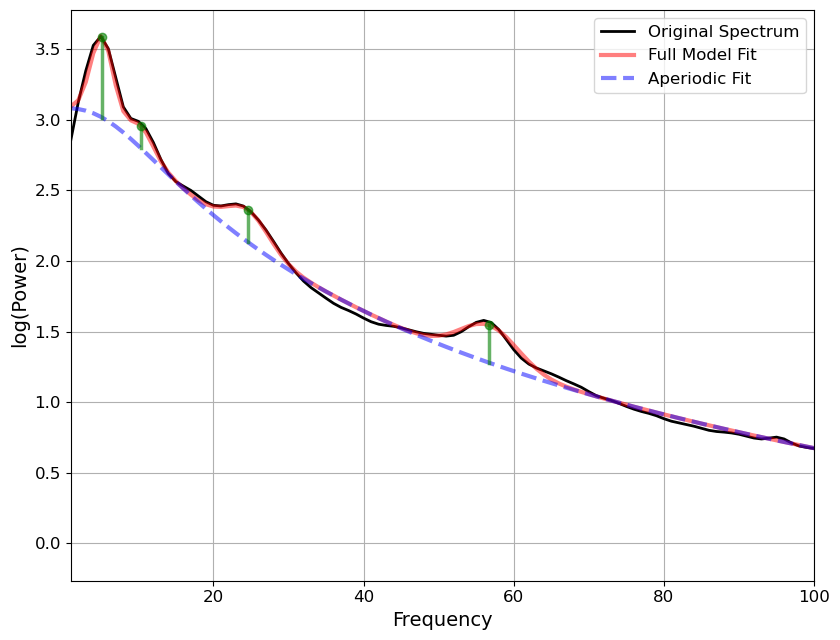

In [17]:
ax = plots.plot_fooof_quick(fooof_result[1], freq_range=plt_range)
plt.show()

In [18]:
band = spec.get_fooof_freq_band(fooof_result[0], (50., 70.), top_n_peaks=2, bandwidth_n_sigma=2.)[0]

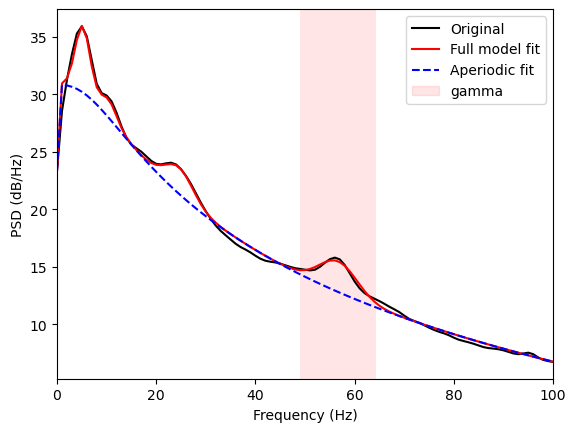

In [19]:
ax = plots.plot_fooof(psd_da, fooof_result=fooof_result[0], freq_range=plt_range)
plots.plot_freq_band([band], ['gamma'], ax=ax)
plt.show()